In [45]:
import numpy as np
import pylab

In [46]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    print(Y)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


In [47]:
import sys
from PIL import Image
from os import listdir
from os.path import isfile, join, isdir

images = []

path = '../MIT-7-Classes-Visualization/Imgs'

directories = [f for f in listdir(path) if isdir(join(path, f))]

for val in directories:
    images.extend([path+'/'+val+'/'+f for f in listdir(path+'/'+val) if isfile(join(path+'/'+val, f))])

In [48]:
import scipy.io as sio

pathFeats = '../MIT-7-Classes-Visualization/Feats'
pathsX = []
X = []

labels = []
np.array([np.float64(0),np.float64(1),np.float64(2),np.float64(3),np.float64(4),np.float64(5),np.float64(6)])
number = 0

for val in directories:
    inicio= len(pathsX)
    pathsX.extend([pathFeats+'/'+val+'/'+f for f in listdir(pathFeats+'/'+val) if isfile(join(pathFeats+'/'+val, f))])
    fin= len(pathsX)
    for i in range(fin-inicio):
        labels.append(np.float64(number))
    number += 1
    
for val in pathsX:
    value = sio.loadmat(val)['stored'][0]
    X.append(value)

In [49]:
def jpg_image_to_array(image_path):
  """
  Loads JPEG image into 3D Numpy array of shape 
  (width, height, channels)
  """
  with Image.open(image_path) as image:
    image = image.resize((256, 256))
    im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
    im_arr = im_arr.reshape((image.size[1], image.size[0], 3))                                   
    return im_arr

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [51]:
Xnormalized = []

for val in X:
    normal = normalized(val)[0]
    Xnormalized.append(normal)
    
Xnormalized = np.array(Xnormalized)
labels = np.array(labels)
    
print(Xnormalized)
print(labels)

[[0.         0.00586971 0.         ... 0.         0.         0.01786702]
 [0.00783499 0.03058988 0.01373257 ... 0.         0.         0.00612707]
 [0.02613143 0.         0.00642831 ... 0.01493539 0.         0.01155271]
 ...
 [0.02727301 0.03420416 0.02615687 ... 0.02830551 0.         0.03625271]
 [0.03596397 0.         0.         ... 0.00993269 0.         0.04855487]
 [0.03234787 0.         0.         ... 0.02202985 0.         0.03481499]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Preprocessing the data using PCA...
[[ 0.44782532 -1.27313761]
 [ 0.71401225  0.14373525]
 [-0.43060297 -0.93112658]
 ...
 [-0.81840296 -2.05917169]
 [-0.76341281  0.51782033]
 [-0.45669408  0.63935343]]
Computing pairwise distances...
Computing P-values for point 0 of 558...
Computing P-values for point 500 of 558...
Mean value of sigma: 0.181645
Iteration 10: error is 16.557019
Iteration 20: error is 14.938975
Iteration 30: error is 14.368559
Iteration 40: error is 13.948274
Iteration 50: error is 13.755458
Iteration 60: error is 13.792751
Iteration 70: error is 13.829936
Iteration 80: error is 13.792316
Iteration 90: error is 13.755128
Iteration 100: error is 13.829983
Iteration 110: error is 1.606544
Iteration 120: error is 1.189686
Iteration 130: error is 1.048024
Iteration 140: error is 0.982834
Iteration 150: error is 0.943401
Iteration 160: error is 0.916132
Iteration 170: error is 0.896990
Iteration 18

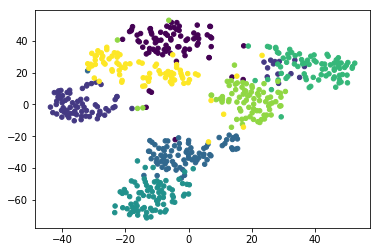

In [52]:
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    Y = tsne(Xnormalized, 2, 50, 20.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


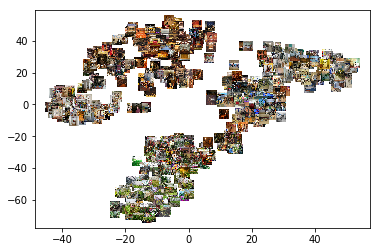

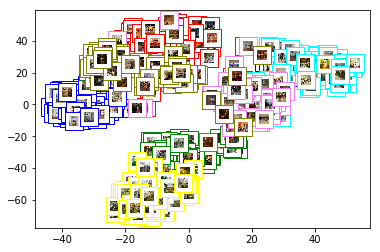

In [58]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import matplotlib.pyplot as plt
from skimage import transform

colors = ['red','blue','green','yellow','cyan','violet','olive']

def main(colors=None):
    fig, ax = plt.subplots()
    imscatter(Y, images, colors, zoom=0.1, ax=ax)
    ax.update_datalim(Y)
    ax.autoscale()
    plt.show()

def imscatter(Y, images, colors, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    artists = []
    iteration = 0
    for x,y in Y:
        imagepath= images[iteration]
        try:
            image = plt.imread(imagepath)
        except TypeError:
            # Likely already an array...
            pass
        image = transform.resize(image,(100,100))
        im = OffsetImage(image, zoom=zoom)
        if (colors == None):
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
        else:
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=True,bboxprops=dict(edgecolor=colors[int(labels[iteration])]))
        artists.append(ax.add_artist(ab))
        iteration += 1
    ax.update_datalim(Y)
    ax.autoscale()
    return artists

main()
main(colors)